## 2: Fourier Series

It is a fact that any $2\pi$-periodic, square-integrable function can be written in terms of a fourier-expansion.
For practical purposes (computation of the derivative), we choose the exponential form:
$$ 
f(x) = \sum_{n=-\infty}^{\infty} c_n e^{i n x} \\
c_n = \frac{1}{2\pi} \int_{-\pi}^{\pi} f(x)\, e^{-i n x} \, dx
$$

The goal of this program is to compute the derivative of any $2\pi$-periodic, square-integrable function by making use of the DeepONet architecture.

In [1]:
#Import the necessary modules
import torch
import torch.nn as nn
import torch.nn.functional as F #Includes the activation functions

import math
import matplotlib.pyplot as plt 
import numpy as np

torch.manual_seed(0) #for reproducible results

Epoch 1 | MSE Loss = 114.09107208251953
Epoch 201 | MSE Loss = 100.07145690917969
Epoch 401 | MSE Loss = 89.2037353515625
Epoch 601 | MSE Loss = 59.510658264160156
Epoch 801 | MSE Loss = 34.6875
Epoch 1001 | MSE Loss = 23.022506713867188
Epoch 1201 | MSE Loss = 18.539905548095703
Epoch 1401 | MSE Loss = 12.611018180847168
Epoch 1601 | MSE Loss = 8.653493881225586
Epoch 1801 | MSE Loss = 11.911447525024414
Epoch 2001 | MSE Loss = 8.348843574523926
Epoch 2201 | MSE Loss = 9.346830368041992
Epoch 2401 | MSE Loss = 7.495319366455078
Epoch 2601 | MSE Loss = 7.184347152709961
Epoch 2801 | MSE Loss = 7.11252498626709
Epoch 3001 | MSE Loss = 5.583341121673584
Epoch 3201 | MSE Loss = 4.857240676879883
Epoch 3401 | MSE Loss = 5.455666542053223
Epoch 3601 | MSE Loss = 3.572122812271118
Epoch 3801 | MSE Loss = 5.769339084625244
Epoch 4001 | MSE Loss = 9.829014778137207
Epoch 4201 | MSE Loss = 4.335272312164307
Epoch 4401 | MSE Loss = 3.2357752323150635
Epoch 4601 | MSE Loss = 2.3413162231445312
Ep

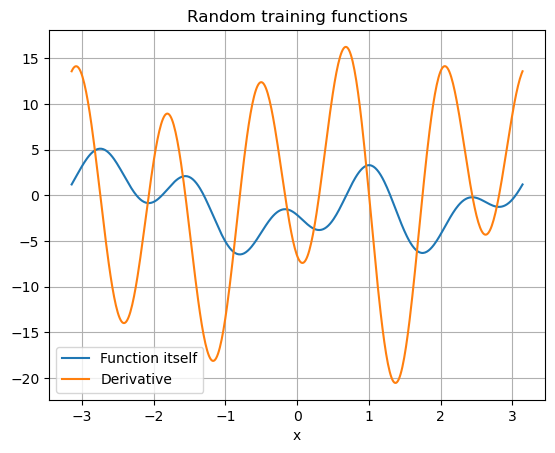

In [2]:
#Define branch net (Same as before)
class BranchNet(nn.Module):
    def __init__(self,m_dim,p_dim,depth=3):
        super().__init__()
        layers = [nn.Linear(m_dim,p_dim),nn.Tanh()] #First linear layer with tanh activation function m_dim-> p_dim
        for _ in range(depth-1):
            layers += [nn.Linear(p_dim,p_dim),nn.Tanh()] #Hidden layers with tanh activation function p_dim->p_dim
        self.net = nn.Sequential(*layers)
    def forward(self,func_at_sensors):
        return self.net(func_at_sensors)
#Define trunk net (Same as before)
class TrunkNet(nn.Module):
    def __init__(self,p_dim,depth=3):
        super().__init__()
        layers = [nn.Linear(1,p_dim),nn.Tanh()] #First linear layer with tanh activation function 1-> p_dim
        for _ in range(depth-1):
            layers += [nn.Linear(p_dim,p_dim),nn.Tanh()] #Hidden layers with tanh activation function 1->p_dim
        self.net = nn.Sequential(*layers)
    def forward(self,y):
        return self.net(y)
        

#Define DeepONet as a combination of branch and trunk net (Same as before)
class DeepONet(nn.Module):
    def __init__(self,m_dim,p_dim):
        super().__init__()
        self.branch = BranchNet(m_dim,p_dim)
        self.trunk = TrunkNet(p_dim)
    def forward(self,func_at_sensors,y):
        b = self.branch(func_at_sensors)
        t = self.trunk(y)
        return torch.sum(b*t,dim=1,keepdim=True)

#Training
sensor_points_num = 500 #How many sensor points to consider
eval_num = 200 #How many y-points to consider
p_dim = 500
model = DeepONet(sensor_points_num,p_dim)


optimizer = torch.optim.Adam(model.parameters(),lr=1e-3)
loss_MSE = torch.nn.MSELoss()
sensor_points = torch.linspace(-math.pi,math.pi,sensor_points_num) #create equidistant sensor points
y = torch.linspace(-math.pi,math.pi,eval_num)

def generate_exponential_fourier_functions(num_funcs, sensor_points, K=5):
    """
    Generate periodic functions with their exact analytical derivative in exponential form
    f(x) = sum_{n=-K}^{K} c_n * exp(i n x)
    f'(x) = sum_{n=-K}^{K} (i n) * c_n * exp(i n x)
    """
    m = sensor_points.shape[0]
    sensor_points = sensor_points[None, :]  # shape (1, m)

    n_vals = torch.arange(-K, K+1).view(1, 2*K+1, 1)  # (1, 2K+1, 1)
    x = sensor_points.view(1, 1, m)  # (1, 1, m)

    # Random complex coefficients
    a_n = torch.randn(num_funcs, 2*K+1, 1)
    b_n = torch.randn(num_funcs,2*K+1, 1)
    c_n = a_n + 1j * b_n  # shape (batch, 2K+1, 1)

    # Compute exp(i n x)
    exp_inx = torch.exp(1j* n_vals* x)  # shape (1, 2K+1, m)

    f_complex = (c_n *exp_inx).sum(dim=1) # shape (batch, m)
    f_deriv_complex = (1j * n_vals *c_n *exp_inx).sum(dim=1)

    # Take real part to ensure real-valued functions
    f = f_complex.real
    f_deriv = f_deriv_complex.real

    return f, f_deriv

#Sanity check
f,f_deriv = generate_exponential_fourier_functions(1,sensor_points)

plt.plot(sensor_points,f.squeeze(),label="Function itself")
plt.plot(sensor_points,f_deriv.squeeze(),label="Derivative")
plt.grid()
plt.xlabel("x")
plt.title("Random training functions")
plt.legend()

func_num = 1000 #How many training functions to consider
f,f_deriv = generate_exponential_fourier_functions(func_num,sensor_points)

for epoch in range(10000):
    #To solve dim. problem divide into batches
    batch_size = 256

    # Randomly sample function indices and point indices
    func_id = torch.randint(0, func_num, (batch_size,)) 
    y_id    = torch.randint(0, sensor_points_num, (batch_size,))
    f_batch = f[func_id] 
    y_batch = sensor_points[y_id].unsqueeze(1)

    # Get the true derivative at those coordinates
    label = f_deriv[func_id, y_id].unsqueeze(1)

    predicted = model(f_batch,y_batch)
    loss = loss_MSE(predicted,label)
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()
    if epoch % 200 == 0:
        print("Epoch {0} | MSE Loss = {1}".format(epoch+1,loss))


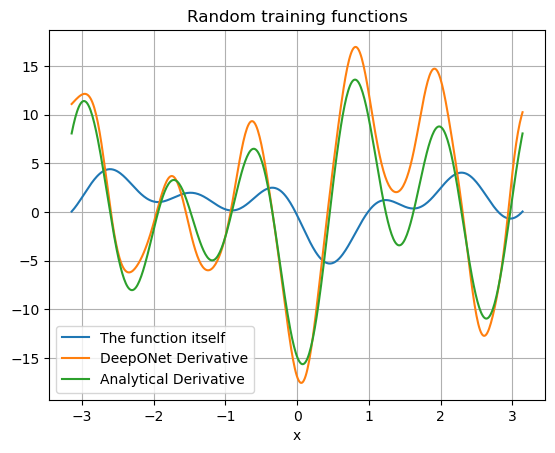

In [3]:
#Inference: Test the model for a function
f,f_der = generate_exponential_fourier_functions(1,sensor_points)
f_model = model(f.repeat(sensor_points_num,1),sensor_points.unsqueeze(1))
plt.plot(sensor_points,f.detach().squeeze(),label="The function itself")
plt.plot(sensor_points,f_model.detach().squeeze(),label="DeepONet Derivative")
plt.plot(sensor_points,f_der.squeeze(),label="Analytical Derivative")
plt.grid()
plt.xlabel("x")
plt.title("Random training functions")
plt.legend()